In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
33,5.5,4.2,1.4,0.2,Iris-setosa
123,6.3,2.7,4.9,1.8,Iris-virginica
75,6.6,3.0,4.4,1.4,Iris-versicolor
86,6.7,3.1,4.7,1.5,Iris-versicolor
92,5.8,2.6,4.0,1.2,Iris-versicolor
...,...,...,...,...,...
17,5.1,3.5,1.4,0.3,Iris-setosa
126,6.2,2.8,4.8,1.8,Iris-virginica
56,6.3,3.3,4.7,1.6,Iris-versicolor
96,5.7,2.9,4.2,1.3,Iris-versicolor


In [3]:
labels_column_name = "label"
jackknife_idx = np.random.randint(0, iris_dataset.shape[0])
train_set = iris_dataset.loc[
        iris_dataset.index != jackknife_idx
    ].drop(columns=labels_column_name).values
train_labels = iris_dataset.loc[
        iris_dataset.index != jackknife_idx,
        labels_column_name
    ].values
test_set = iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ].drop(columns=labels_column_name).values
test_labels = iris_dataset.loc[
        iris_dataset.index == jackknife_idx,
        labels_column_name
    ].values
test_instance = test_set[0]

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 10)
random_forest.fit(train_set, train_labels)
unique_labels = random_forest.classes_

prediction = random_forest.predict(test_set)
prediction_probabilities = random_forest.predict_proba(test_set)
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-setosa']. Probabilities: [[1. 0. 0.]]


### Use LIME to explain prediction

,sepal_length,sepal_width,petal_length,petal_width,label
25,5.0,3.0,1.6,0.2,Iris-setosa


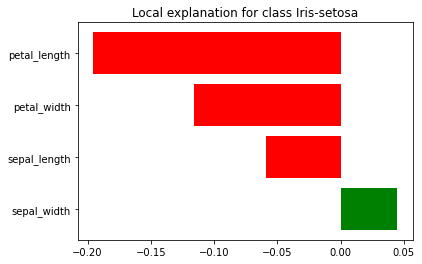

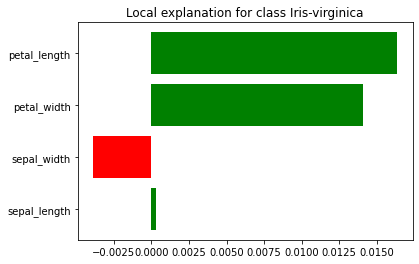

In [4]:
importlib.reload(lime.lime_tabular_mod)
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = unique_labels,
    discretize_continuous=False,
    sample_around_instance=True
)
explanation = explainer.explain_instance(
    test_instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3,
    # distance_metric="minkowski",
    # minkowski_norm=100.
)
for label in explanation.top_labels[:2]:
    _ = explanation.as_pyplot_figure(label)
iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ]

In [5]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))
print(explanation.get_scores_for_surrogate_model())
print(explanation.get_losses_for_surrogate_model())
print(explanation.get_fidelity_loss_on_explanation())
print(explanation.get_fidelity_loss_on_generated_data())


[1. 0. 0.]
[0.7364365253739766, 0.25435194894821317, 0.00921152567781023]
[0.47602206 0.29394116 0.23003678]
[0.5572032517169115, 0.49154763106890664, 0.09730981973053565]
[0.03544317209687638, 0.04210663720266259, 0.00845038583882567]
0.13795706931016696
0.06568679639048863


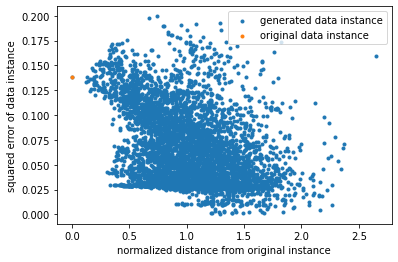

In [6]:
squared_errors = explanation.get_fidelity_loss_distribution()
explanation.plot_fidelity_map()

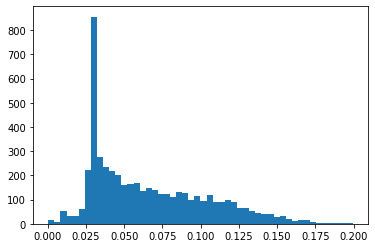

In [7]:
plt.hist(squared_errors, bins=50)
plt.show()

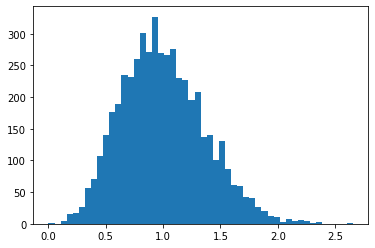

In [8]:
plt.hist((squared_errors.index)/np.mean(squared_errors.index.values), bins=50)
plt.show()

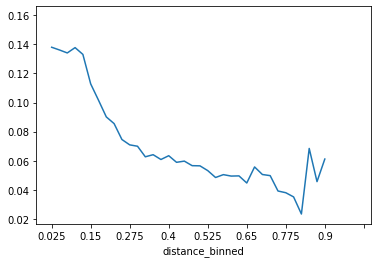

In [9]:
binned = explanation.get_fidelity_loss_distribution(bins=40)
binned.plot()
plt.show()

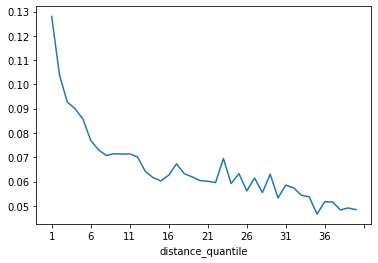

In [10]:
percentiles = explanation.get_fidelity_loss_distribution(quantiles=40)
percentiles.plot()
plt.show()